In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.plotting import figure, show, output_file
import seaborn as sns

In [2]:
train = pd.read_csv('data/train.csv')
train = train.replace('\\N',np.NAN)
n,p = train.shape
train.head()

,id,STRUCTURE PRESCRIPTRICE,PLATEFORME,year,month,region,ORIENTATION,NATURE_DIFF,age,tranche_age,...,nb_immo,crd_immo,nb_rac,crd_rac,nb_autres,crd_autres,nb_decouvert,crd_decouvert,moy_eco_jour,cat_moy_eco_jour
0,1550,PRESCRIPTEUR35,bancaire,2015,7,BOURGOGNE FRANCHE COMTE,Surendettement,Surendettement,NaN,Non Renseigne,...,0,NaN,0,NaN,0,NaN,0,NaN,"2,53333","0a2,99€"
1,2249,PRESCRIPTEUR16,bancaire,2016,2,OCCITANIE,Mediation,Endettement,NaN,Non Renseigne,...,0,NaN,0,NaN,0,NaN,0,NaN,"-3,31667",Négatif
2,2670,PRESCRIPTEUR18,social,2016,4,PROVENCE-ALPES-COTE-D'AZUR,Accompagnement,Endettement,NaN,Non Renseigne,...,0,NaN,0,NaN,1,3996,0,NaN,"-24,7667",Négatif
3,1102,PRESCRIPTEUR6,bancaire,2014,11,BRETAGNE,Mediation,Multiendettement,NaN,Non Renseigne,...,0,NaN,0,NaN,0,NaN,0,NaN,"29,5667",15€et+
4,7069,PRESCRIPTEUR23,social,2018,9,NOUVELLE AQUITAINE,Accompagnement,Difficultés de Gestion,24,<25ans,...,0,NaN,0,NaN,0,NaN,0,NaN,"-19,15",Négatif


## I - Traitement des types

In [3]:
train.columns.to_series().groupby(train.dtypes.astype(str)).groups['object']

Index(['STRUCTURE PRESCRIPTRICE', 'PLATEFORME', 'region', 'ORIENTATION',
       'NATURE_DIFF', 'age', 'tranche_age', 'situation', 'adulte_foyer',
       'PROF', 'LOGEMENT', 'cat_rev', 'cat_charges', 'cat_credit',
       'IMPAYES_DEBUT', 'cat_impayes', 'cat_RAV_ouverture', 'RAV_UC',
       'cat_RAV_UC', 'CRD', 'gain_mediation', 'crd_amort', 'crd_renouv',
       'crd_immo', 'crd_rac', 'crd_autres', 'crd_decouvert', 'moy_eco_jour',
       'cat_moy_eco_jour'],
      dtype='object')

### • Numeric

In [4]:
for c in train.columns:
    if 'crd_' in c or c in ['CRD','IMPAYES_DEBUT','age','adulte_foyer']:
        train[c] = pd.to_numeric(train[c], errors='coerce')

### • Float

In [5]:
train.moy_eco_jour = train.moy_eco_jour.str.replace(',', '.', regex=False).astype(float)
train.RAV_UC = train.RAV_UC.str.replace(',', '.', regex=False).astype(float)

### • Date

In [6]:
train['Date'] = pd.to_datetime(train.year.astype(str) + '-' + train.month.astype(str), format='%Y-%m')
train = train.drop(columns=['year','month'])

## II - Traitement des NA

In [7]:
train = train.replace('Non Renseigne', np.NAN)

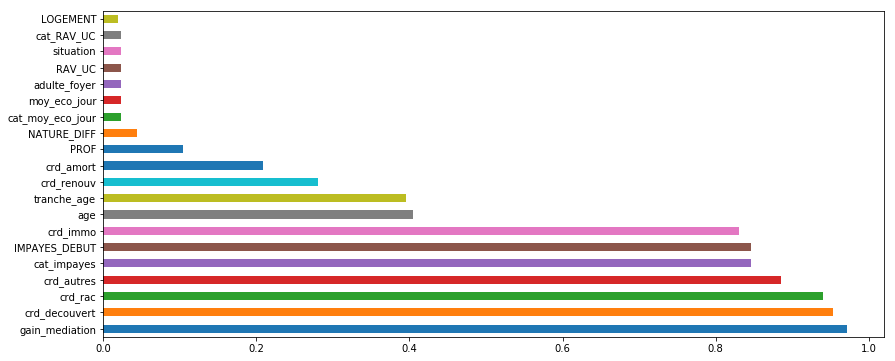

In [8]:
train_na = train.isna().sum()/train.shape[0]

plt.figure(figsize=(14,6))
train_na.sort_values(ascending=False)[:20].plot(kind='barh')
plt.show()

Certaines colonnes contiennent plus de **80%** de **NA** ce qui est beaucoup **trop important** pour appliquer une méthode de **fillna**. 

### • CRD et nb

In [9]:
train[train.crd_decouvert.isna()][['crd_decouvert','nb_decouvert']].sum()

crd_decouvert    0.0
nb_decouvert     0.0
dtype: float64

La colonne **crd_decouvert** contient des **NA** lorsque la colonne **nb_couvert**. Ce n'est donc pas un vrai manque de valeur. Nous pouvons remplacer ces **NA** par **0**.

Vérifions cette hypothèse pour les colonnes **CRD - nb**.

In [10]:
for CRD in train.columns.tolist():
    if 'crd_' in CRD:
        _type = CRD.split('_')[1]
        print('\n')
        print(dict(train[train[CRD].isna()][[CRD,f'nb_{_type}']].sum()))



{'crd_amort': 0.0, 'nb_amort': 0.0}


{'crd_renouv': 0.0, 'nb_renouv': 0.0}


{'crd_immo': 0.0, 'nb_immo': 0.0}


{'crd_rac': 0.0, 'nb_rac': 0.0}


{'crd_autres': 0.0, 'nb_autres': 0.0}


{'crd_decouvert': 0.0, 'nb_decouvert': 0.0}


In [11]:
for CRD in train.columns.tolist():
    if 'crd_' in CRD:
        train[CRD] = train[CRD].fillna(0)
train.head()

,id,STRUCTURE PRESCRIPTRICE,PLATEFORME,region,ORIENTATION,NATURE_DIFF,age,tranche_age,situation,adulte_foyer,...,crd_immo,nb_rac,crd_rac,nb_autres,crd_autres,nb_decouvert,crd_decouvert,moy_eco_jour,cat_moy_eco_jour,Date
0,1550,PRESCRIPTEUR35,bancaire,BOURGOGNE FRANCHE COMTE,Surendettement,Surendettement,NaN,NaN,celibataire,1.0,...,0.0,0,0.0,0,0.0,0,0.0,2.53333,"0a2,99€",2015-07-01
1,2249,PRESCRIPTEUR16,bancaire,OCCITANIE,Mediation,Endettement,NaN,NaN,marie,2.0,...,0.0,0,0.0,0,0.0,0,0.0,-3.31667,Négatif,2016-02-01
2,2670,PRESCRIPTEUR18,social,PROVENCE-ALPES-COTE-D'AZUR,Accompagnement,Endettement,NaN,NaN,celibataire,1.0,...,0.0,0,0.0,1,3996.0,0,0.0,-24.76670,Négatif,2016-04-01
3,1102,PRESCRIPTEUR6,bancaire,BRETAGNE,Mediation,Multiendettement,NaN,NaN,divorce,1.0,...,0.0,0,0.0,0,0.0,0,0.0,29.56670,15€et+,2014-11-01
4,7069,PRESCRIPTEUR23,social,NOUVELLE AQUITAINE,Accompagnement,Difficultés de Gestion,24.0,<25ans,concubinage,2.0,...,0.0,0,0.0,0,0.0,0,0.0,-19.15000,Négatif,2018-09-01


### • Age

In [12]:
#train.tranche_age = train.tranche_age.replace('Non Renseigne', np.NAN)

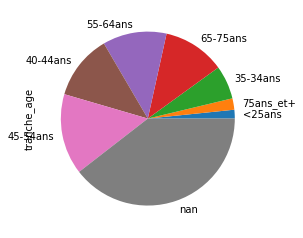

In [13]:
train.tranche_age.value_counts(ascending=True,dropna=False,normalize=True).plot(kind='pie',)

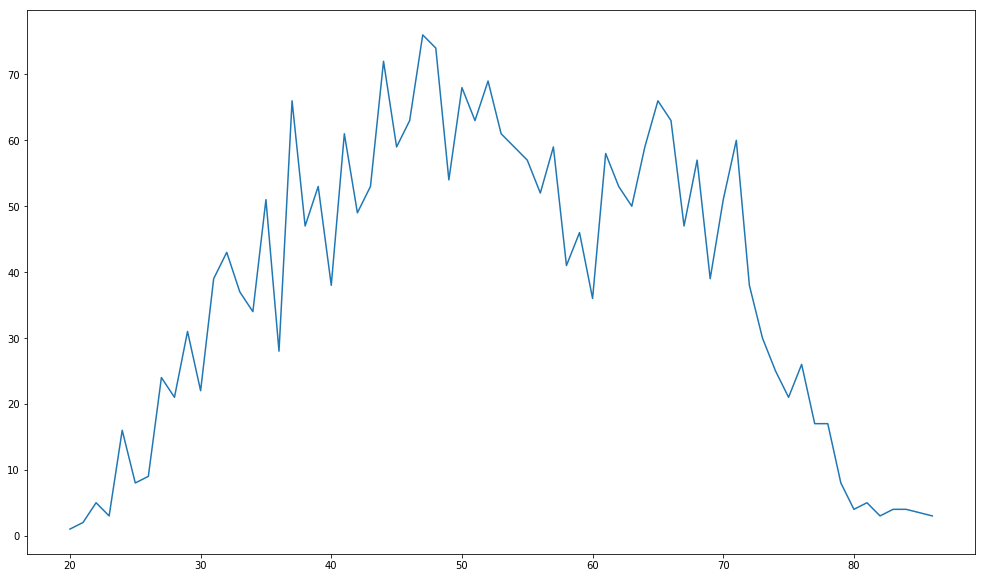

In [14]:
ar = pd.DataFrame({'age':train.age.value_counts().index,'nb':train.age.value_counts().values}).sort_values('age')
fig = plt.figure(figsize=(17, 10))
plt.plot(ar.age,ar.nb)

In [15]:
round(train.age.isna().sum()/train.age.shape[0],ndigits=3)

0.405

La répartition de l'**âge** est intéressante, on semble distinguer une **hyperbole centrée en 52**. Cependant il y a tout de même trop de **NA** (**40%**) pour les remplacer par la **mediane** de la colonne **âge**. On  pourrait cependant utiliser la **median/moyenne** d'âge en groupant par **region, profession ou personne à charge**.

In [16]:
train.age.mean()

52.0992963252541

In [17]:
for p in train.PROF.unique():
    med = train.loc[train.PROF == p].age.median()
    train.loc[train.PROF == p, 'age'] = train.loc[train.PROF == p, 'age'].fillna(med)
train.age.mean()

52.28862077123255

In [18]:
train.tranche_age.unique().tolist()

[nan,
 '<25ans',
 '35-34ans',
 '55-64ans',
 '75ans_et+',
 '45-54ans',
 '40-44ans',
 '65-75ans']

In [19]:
def trancheAge(x):
    age = x.age
    if age < 25:
        return '<25ans'

    elif age >= 25 and age <= 34:
        return  '25-34ans'

    elif age >= 35 and age <= 44:
        return  '35-44ans'

    elif age >= 45 and age <= 54:
        return  '45-54ans'

    elif age >= 55 and age <= 64:
        return  '55-64ans'

    elif age >= 65 and age <= 74:
        return  '65-74ans'

    elif age >= 75:
        return '>75ans'

In [20]:
train.tranche_age = train.apply(lambda x: trancheAge(x), axis=1)

### • IMPAYES DEBUT

In [21]:
print(f'MAX: {pd.to_numeric(train.IMPAYES_DEBUT, errors="coerce").max()}')
print(f'MIN: {pd.to_numeric(train.IMPAYES_DEBUT, errors="coerce").min()}')
print(f'Median: {pd.to_numeric(train.IMPAYES_DEBUT, errors="coerce").median()}')
print(f'Moyenne: {round(pd.to_numeric(train.IMPAYES_DEBUT, errors="coerce").mean())}')
print(f'NA: {round(train.IMPAYES_DEBUT.isna().sum()/train.shape[0],ndigits=2)}')

MAX: 10889.0
MIN: 35.0
Median: 1107.5
Moyenne: 1199
NA: 0.85


Cette colonne contient beaucoup beaucoup **trop de NA**. Je ne vois pas, **pour l'instant**, de méthode pour la combler.

Nous la supprimons **pour l'instant**.

In [22]:
train = train.drop(columns=['IMPAYES_DEBUT'])

### • GAIN MEDIATION

In [23]:
print(f'MAX: {pd.to_numeric(train.gain_mediation, errors="coerce").max()}')
print(f'MIN: {pd.to_numeric(train.gain_mediation, errors="coerce").min()}')
print(f'Median: {pd.to_numeric(train.gain_mediation, errors="coerce").median()}')
print(f'Moyenne: {round(pd.to_numeric(train.gain_mediation, errors="coerce").mean())}')
print(f'NA: {round(train.gain_mediation.isna().sum()/train.shape[0],ndigits=2)}')

MAX: 4359.0
MIN: -16.0
Median: 514.0
Moyenne: 686
NA: 0.97


In [24]:
train.gain_mediation.unique()

array([nan, '32', '456', '309', '508', '613', '562', '-16', '1320', '554',
       '514', '1243', '1382', '181', '4359', '885', '555', '236', '1321',
       '321', '252', '267', '552', '238', '733', '434', '952', '126',
       '1375', '956', '0', '394', '139', '297', '116', '338', '275',
       '1211', '292', '595', '1567', '543', '1168', '1169', '1924', '495',
       '114', '384', '2154', '1634', '1391', '843', '156', '213', '1727',
       '720', '545', '1307', '90', '2328', '825', '975', '902', '1064',
       '306', '459', '1051', '232', '754', '326', '433', '25', '656',
       '122', '308', '391', '1405', '198', '903', '425', '986', '999',
       '168', '476', '591', '322', '779', '1424', '891', '60', '553',
       '1359', '173', '343', '302', '1012', '96', '673', '1908', '725',
       '405', '94', '151', '671', '341', '453', '274', '24', '770', '167',
       '2419', '1723', '333', '526', '688', '74', '485', '544', '475'],
      dtype=object)

In [25]:
train.gain_mediation = train.gain_mediation.fillna(0).astype(int)

### • cat_impayes

In [26]:
train.cat_impayes.value_counts(dropna=False)

NaN              3635
1000€-1500€       246
500€-1000€        236
1501€-2000€       108
1€-499€            36
2001€-3000€        31
3001€-4000€         4
6000€ et plus       2
5001€-6000€         1
Name: cat_impayes, dtype: int64

Le nombre de **NA** pour cette colonne est **trop important** pour les supprimer. Cette colonnes étant catégorielle, **pouvons les conserver**.

In [27]:
train.cat_impayes = train.cat_impayes.fillna('Inconnu')

### -> Résultat du nettoyage des NA

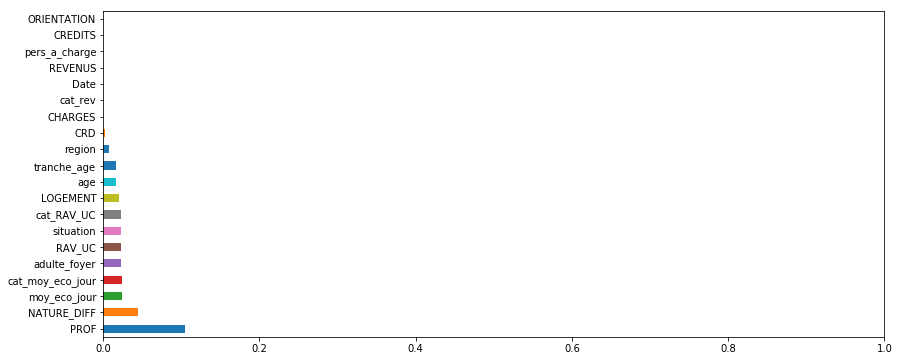

In [28]:
train_na = train.isna().sum()/train.shape[0]

fig, ax = plt.subplots()
fig.set_size_inches(14,6)
ax.set_xlim([0,1])
train_na.sort_values(ascending=False)[:20].plot(kind='barh')
plt.show()

In [29]:
round(train.dropna().shape[0]/n,ndigits=2)

0.86

Nous pouvons **supprimer** les **NA restants**, soit **14%**.

In [30]:
train = train.dropna()

# III - Traitement des données catégorielles

In [31]:
cols_categorielles = list(train.dtypes[train.dtypes == 'object'].to_dict().keys())
train[cols_categorielles].head()

,STRUCTURE PRESCRIPTRICE,PLATEFORME,region,ORIENTATION,NATURE_DIFF,tranche_age,situation,PROF,LOGEMENT,cat_rev,cat_charges,cat_credit,cat_impayes,cat_RAV_ouverture,cat_RAV_UC,cat_moy_eco_jour
0,PRESCRIPTEUR35,bancaire,BOURGOGNE FRANCHE COMTE,Surendettement,Surendettement,65-74ans,celibataire,retraité,proprietaire,<1150€,500€-1000€,1€-499€,Inconnu,C,C,"0a2,99€"
1,PRESCRIPTEUR16,bancaire,OCCITANIE,Mediation,Endettement,65-74ans,marie,retraité,gratuit,2001€-2500€,500€-1000€,1501€-2000€,Inconnu,C,C,Négatif
2,PRESCRIPTEUR18,social,PROVENCE-ALPES-COTE-D'AZUR,Accompagnement,Endettement,45-54ans,celibataire,employé,locataire,1150€-1500€,500€-1000€,1€-499€,500€-1000€,B,B,Négatif
3,PRESCRIPTEUR6,bancaire,BRETAGNE,Mediation,Multiendettement,65-74ans,divorce,retraité,proprietaire,2001€-2500€,500€-1000€,500€-1000€,Inconnu,A,A,15€et+
4,PRESCRIPTEUR23,social,NOUVELLE AQUITAINE,Accompagnement,Difficultés de Gestion,<25ans,concubinage,employé,locataire,2001€-2500€,1001€-1500€,1€-499€,1000€-1500€,B,B,Négatif


In [32]:
for cc in cols_categorielles:
    cat_dtype = pd.api.types.CategoricalDtype(categories=train[cc].unique().tolist(), ordered=False)
    train[cc] = train[cc].astype(cat_dtype)

In [33]:
train.dtypes.head()

id                            int64
STRUCTURE PRESCRIPTRICE    category
PLATEFORME                 category
region                     category
ORIENTATION                category
dtype: object

(25, 25)


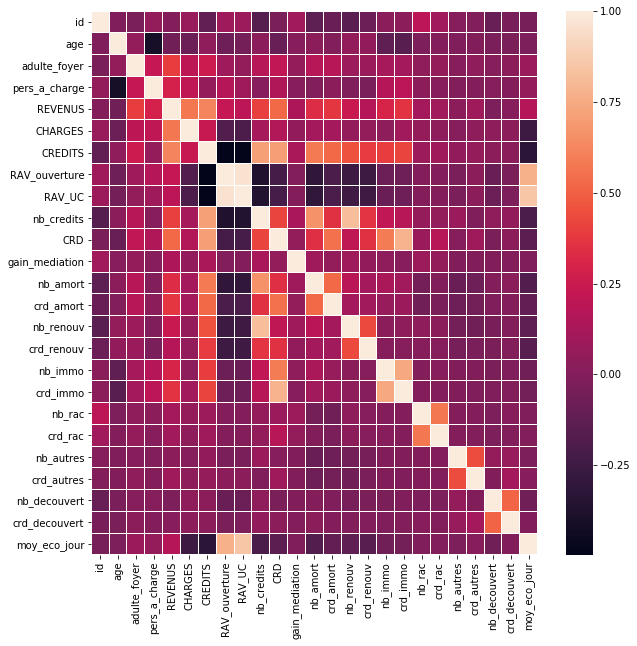

In [34]:
corr = train.corr()
print(corr.shape)
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=.05, ax=ax)

In [35]:
train.shape

(3677, 42)